# Metadata inference

In [1]:
%cd ../gendist/experiments
%load_ext autoreload
%autoreload 2

/home/gerardoduran/documents/shift-happens/gendist/experiments


In [2]:
import jax
import optax
import gendist
import torchvision
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import mnist_rotation_meta as metaexp

In [204]:
%config InlineBackend.figure_format = "retina"

In [82]:
configs = np.linspace(0, 360, 150)
list_configs = [{"angle": float(deg)} for deg in configs]

In [83]:
key = jax.random.PRNGKey(314)
key_subset, key_train = jax.random.split(key)

In [159]:
n_train_subset = 600
mnist_train = torchvision.datasets.MNIST(root=".", train=True, download=True)
X_train = np.array(mnist_train.data) / 255
X_train = metaexp.configure_covariates(key_subset, metaexp.processing_class, X_train, list_configs, n_train_subset)
X_train = X_train * 2 - 1

In [242]:
alpha = 0.00005
# alpha = 0.001
n_epochs = 100
batch_size = 2000

tx = optax.adam(learning_rate=alpha)
lossfn = gendist.training.make_von_mises_loss_func
meta_model = gendist.models.LeNet5Regression(1)
# meta_model = gendist.models.MLPDataV1(1)

configs_radians = configs / 180 * jnp.pi
trainer = gendist.training.TrainingMeta(meta_model, lossfn, tx)

In [243]:
meta_output = trainer.fit(key_train, X_train, configs_radians[None, ...], n_epochs, batch_size)

  0%|          | 0/100 [00:00<?, ?it/s]

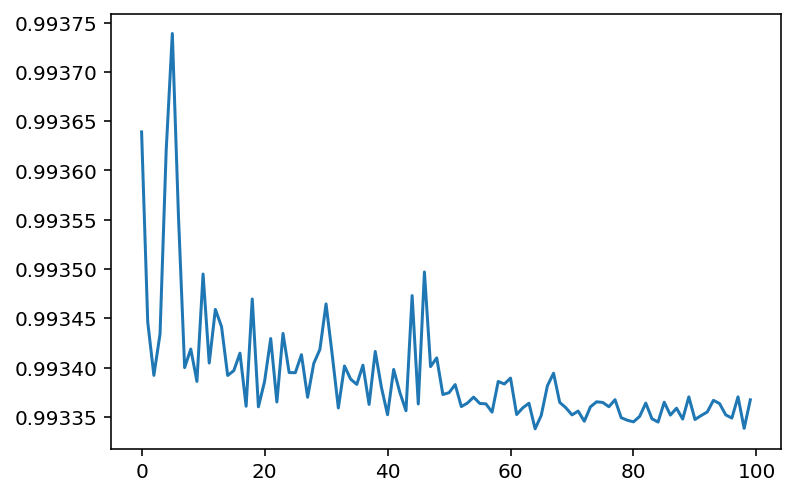

In [244]:
plt.plot(meta_output["losses"])

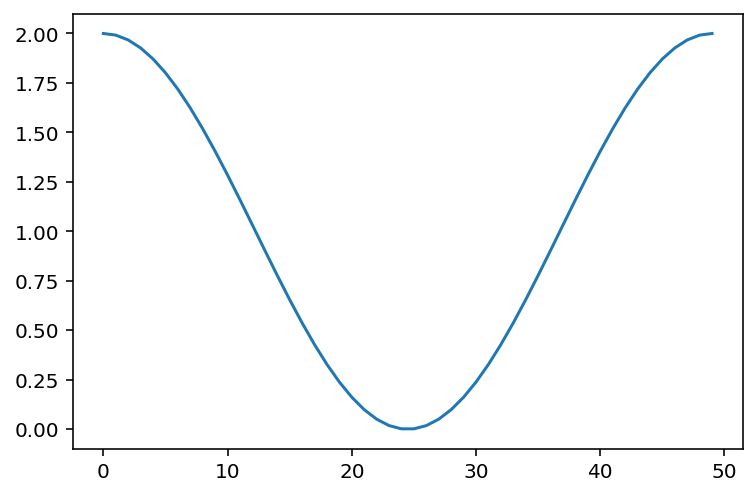

In [241]:
x = jnp.linspace(0, 2 * jnp.pi)
plt.plot(jnp.cos(x) + 1)

In [ ]:
jnp.sqrt(meta_output["losses"])[-10:]

In [172]:
jnp.sqrt(meta_output["losses"])[-10:]

DeviceArray([104.64888 , 104.65269 , 104.653076, 104.651764, 104.662605,
             104.65336 , 104.648094, 104.650826, 104.64987 , 104.64641 ],            dtype=float32)

In [246]:
configs_pred = meta_model.apply(meta_output["params"], X_train.reshape(-1, 28**2))
configs_pred = configs_pred.reshape(600, 150)

In [247]:
configs_pred.min()

DeviceArray(3.0539749, dtype=float32)

In [248]:
configs_pred.max()

DeviceArray(3.264753, dtype=float32)